**DATAFRAME FROM PROJECT 1**

Primero quiero poner aquí todas las librerías que vayamos a utilizar:

In [2]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

# Sklearn imports

from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import KFold
from sklearn import model_selection
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor  
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV

# Statistical tests
from scipy import stats
import scipy.stats as st


In [3]:
%pip install --upgrade openpyxl

Note: you may need to restart the kernel to use updated packages.


In [4]:
# Load data from Excel (change path to your own)
path = r"C:\Users\david\OneDrive\Escritorio\MSC ENERGY SYSTEMS\MACHINE LEARNING\PROJECT\data\dataset.xlsx"
df = pd.read_excel(path)
print(df.head())

   No  X1 transaction date  X2 house age  \
0   1          2012.916667          32.0   
1   2          2012.916667          19.5   
2   3          2013.583333          13.3   
3   4          2013.500000          13.3   
4   5          2012.833333           5.0   

   X3 distance to the nearest MRT station  X4 number of convenience stores  \
0                                84.87882                               10   
1                               306.59470                                9   
2                               561.98450                                5   
3                               561.98450                                5   
4                               390.56840                                5   

   X5 latitude  X6 longitude  Y house price of unit area  
0     24.98298     121.54024                        37.9  
1     24.98034     121.53951                        42.2  
2     24.98746     121.54391                        47.3  
3     24.98746     121.54391  

In [5]:
# Rename each column
df = df.drop(columns=['No','X1 transaction date'])
df = df.rename(columns={
    "X2 house age": "X2_age",
    "X3 distance to the nearest MRT station": "X3_distMRTT",
    "X4 number of convenience stores": "X4_stores",
    "X5 latitude": "X5_lat",
    "X6 longitude": "X6_lon",
    "Y house price of unit area": "Y1_price"
})

# Create new column 'Y2 price category' based on quantiles of 'Y house price of unit area'
df['Y2_pcategory'], bins = pd.qcut(
    df['Y1_price'], 
    q=2, 
    labels=['low', 'high'],
    retbins=True
)

# Create new column 'X5_distcenter' based on 'X5_lat' and 'X6_lon'
CENTER_LAT, CENTER_LON = 25.0375, 121.5637   # degrees
R = 6371.0  # Earth radius in km

lat1 = np.radians(df["X5_lat"])         # or 'lat' if you renamed
lon1 = np.radians(df["X6_lon"])
lat2 = np.radians(CENTER_LAT)
lon2 = np.radians(CENTER_LON)

dlat = lat2 - lat1
dlon = lon2 - lon1

a = np.sin(dlat/2.0)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2.0)**2
c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

df["X5_distcenter"] = R * c

#Reorganize the dataframe
df = df.drop(columns=['X5_lat','X6_lon'])
df = df[["X2_age", "X3_distMRTT", "X4_stores", "X5_distcenter", "Y1_price", "Y2_pcategory"]]
print(df.head())



   X2_age  X3_distMRTT  X4_stores  X5_distcenter  Y1_price Y2_pcategory
0    32.0     84.87882         10       6.506972      37.9          low
1    19.5    306.59470          9       6.807309      42.2         high
2    13.3    561.98450          5       5.910751      47.3         high
3    13.3    561.98450          5       5.910751      54.8         high
4     5.0    390.56840          5       6.809231      43.1         high


**Regression, part a:** In this section, you are to solve a relevant regression problem for your
data and statistically evaluate the result. We will begin by examining the most elementary
model, namely linear regression.

**1. Explain what variable is predicted based on which other variables and what you hope to
accomplish by the regression. Mention your feature transformation choices such as one-of-
K coding. Since we will use regularization momentarily, apply a feature transformation to
your data matrix X such that each column has mean 0 and standard deviation**


In this regression analysis, we aim to predict the continuous variable Y1_price (house price per unit area) based on four predictor variables: X2_age (house age in years), X3_distMRTT (distance to the nearest MRT station in meters), X4_stores (number of nearby convenience stores), and X5_distcenter (distance to the city center in kilometers). The objective of this regression is to build a predictive model that can estimate real estate prices based on physical property characteristics and location-based features, which would be valuable for buyers, sellers, and real estate investors in making informed decisions about property valuations. Regarding feature transformations, no one-of-K encoding is required for this dataset since all predictor variables are already numeric (either continuous or discrete quantitative variables). To prepare the data for regularization techniques that will be applied in subsequent parts of this analysis, we have applied a standardization transformation to the feature matrix X, ensuring that each column has a mean of 0 and a standard deviation of 1.

**2. Introduce a regularization parameter λ as discussed in 14 of the lecture notes, and estimate
the generalization error for different values of λ. Specifically, choose a reasonable range of
values of λ (ideally one where the generalization error first drop and then increases), and
for each value use K = 10 fold cross-validation (algorithm 5) to estimate the generalization
error. Include a figure of the estimated generalization error as a function of λ in the report
and briefly discuss the result**


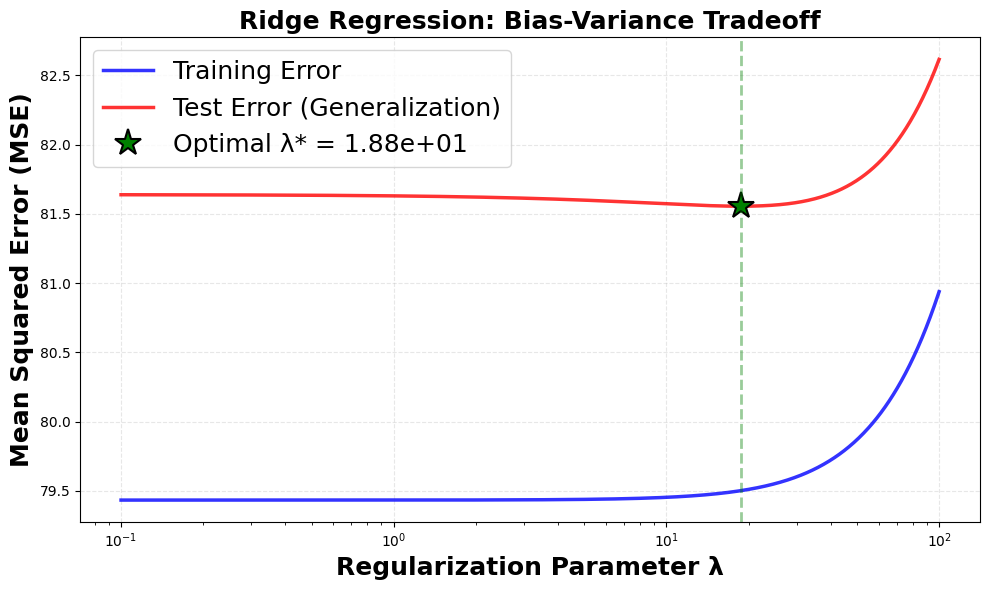

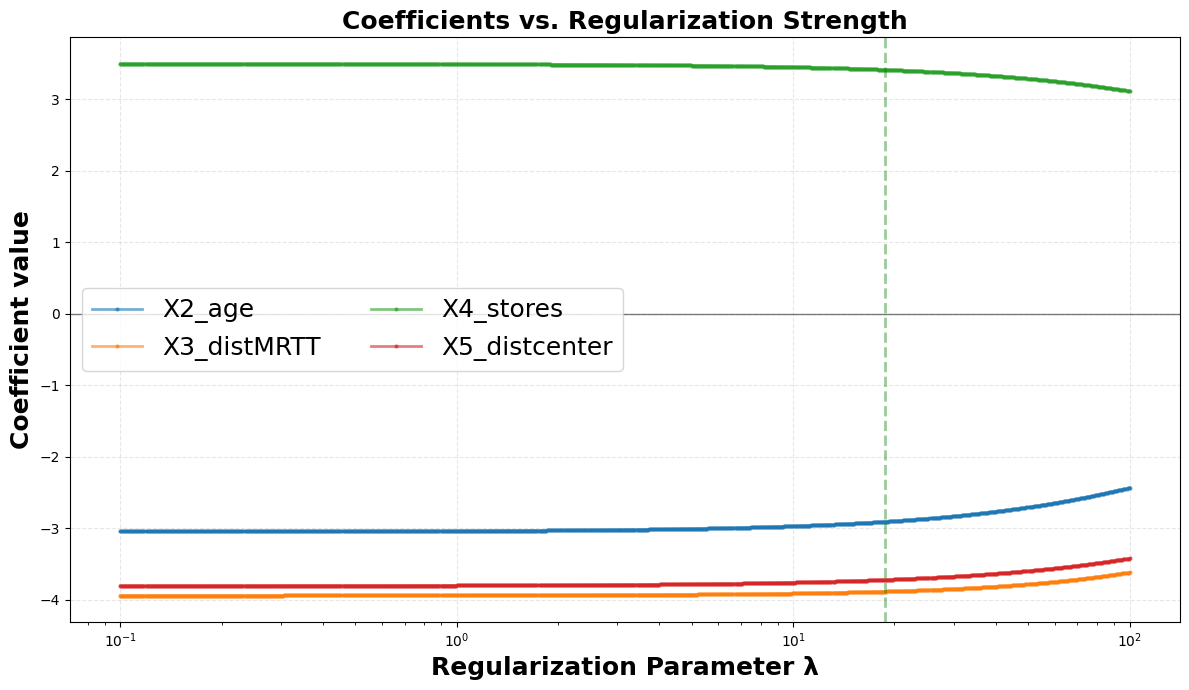

In [11]:
# Preparar datos base
X1 = df.drop(columns=['Y1_price', 'Y2_pcategory']).values
y_r1 = df['Y1_price'].values

# GUARDAR LOS NOMBRES DE LAS CARACTERÍSTICAS
feature_names = df.drop(columns=['Y1_price', 'Y2_pcategory']).columns.tolist()

# Crear features polinomiales 
#poly = PolynomialFeatures(degree=3, include_bias=False)
#X1 = poly.fit_transform(X1)

# Define range of lambda values
num_lambdas = 1000
lambdas = np.logspace(-1, 2, num_lambdas)

# Setup
K = 10
CV = KFold(n_splits=K, shuffle=True, random_state=42)

# Storage for errors
train_errors = np.empty((K, num_lambdas))
test_errors = np.empty((K, num_lambdas))

# K-fold cross-validation loop (SOLO para errores)
for fold_idx, (train_index, test_index) in enumerate(CV.split(X1, y_r1)):
    X_train, y_train = X1[train_index], y_r1[train_index]
    X_test, y_test = X1[test_index], y_r1[test_index]
    
    # Standardize
    scaler = StandardScaler()
    X_train_standardized = scaler.fit_transform(X_train)
    X_test_standardized = scaler.transform(X_test)
    
    # Loop over all lambda values
    for lambda_idx, regularization_strength in enumerate(lambdas):
        
        model = Ridge(alpha=regularization_strength)
        model.fit(X_train_standardized, y_train)
        
        y_train_pred = model.predict(X_train_standardized)
        y_test_pred = model.predict(X_test_standardized)
        
        train_errors[fold_idx, lambda_idx] = np.mean((y_train - y_train_pred)**2)
        test_errors[fold_idx, lambda_idx] = np.mean((y_test - y_test_pred)**2)

# Compute average errors across all folds
train_error_avg = np.mean(train_errors, axis=0)
test_error_avg = np.mean(test_errors, axis=0)

# Find optimal lambda
optimal_lambda_idx = np.argmin(test_error_avg)
optimal_lambda = lambdas[optimal_lambda_idx]
min_test_error = test_error_avg[optimal_lambda_idx]

# CALCULAR COEFICIENTES CON TODO EL DATASET (para visualización)
scaler_full = StandardScaler()
X1_standardized_full = scaler_full.fit_transform(X1)

coefficients = np.empty((num_lambdas, X1.shape[1]))
for lambda_idx, regularization_strength in enumerate(lambdas):
    model = Ridge(alpha=regularization_strength)
    model.fit(X1_standardized_full, y_r1)
    coefficients[lambda_idx, :] = model.coef_

# PLOT 1: Bias-Variance Tradeoff
fig1, ax1 = plt.subplots(figsize=(10, 6))
ax1.semilogx(lambdas, train_error_avg, 'b-', linewidth=2.5, label='Training Error', alpha=0.8)
ax1.semilogx(lambdas, test_error_avg, 'r-', linewidth=2.5, label='Test Error (Generalization)', alpha=0.8)
ax1.semilogx(optimal_lambda, min_test_error, 'g*', markersize=20, 
             label=f'Optimal λ* = {optimal_lambda:.2e}', markeredgecolor='black', markeredgewidth=1.5)
ax1.axvline(x=optimal_lambda, color='green', linestyle='--', alpha=0.4, linewidth=2)
ax1.set_xlabel('Regularization Parameter λ', fontsize=18, fontweight='bold')
ax1.set_ylabel('Mean Squared Error (MSE)', fontsize=18, fontweight='bold')
ax1.set_title('Ridge Regression: Bias-Variance Tradeoff', fontsize=18, fontweight='bold')
ax1.legend(loc='best', fontsize=18)
ax1.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# PLOT 2: Coefficients vs Regularization (CON LEYENDA)
fig2, ax2 = plt.subplots(figsize=(12, 7))
for feature_idx in range(coefficients.shape[1]):
    ax2.plot(lambdas, coefficients[:, feature_idx], 
             linewidth=2, alpha=0.6, marker='o', markersize=2,
             label=feature_names[feature_idx])  # AÑADIR LABEL

ax2.set_xscale('log')
ax2.set_xlabel('Regularization Parameter λ', fontsize=18, fontweight='bold')
ax2.set_ylabel('Coefficient value', fontsize=18, fontweight='bold')
ax2.set_title('Coefficients vs. Regularization Strength', fontsize=18, fontweight='bold')
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)
ax2.axvline(x=optimal_lambda, color='green', linestyle='--', linewidth=2, alpha=0.4)

# AÑADIR LEYENDA
ax2.legend(loc='best', fontsize=18, ncol=2)  # ncol=2 para 2 columnas si tienes muchas features

plt.tight_layout()
plt.show()

**3. Explain how the output, y, of the linear model with the lowest generalization error (as
determined in the previous question) is computed for a given input x. What is the effect
of an individual attribute in x on the output, y, of the linear model? Does the effect of
individual attributes make sense based on your understanding of the problem?**


The Ridge regression model with the lowest generalization error (optimal λ*) computes the predicted house price ŷ for a given input x through the following steps:

1. **Standardization of input features:**
   - Each feature in the input vector x is standardized using the mean (μ) and standard deviation (σ) computed from the training data:
   
   **x̂ = (x - μ) / σ**

2. **Linear combination with learned weights:**
   - The model computes a weighted sum of the standardized features plus an intercept term:
   
   **ŷ = w₀ + w₁·x̂₁ + w₂·x̂₂ + w₃·x̂₃ + w₄·x̂₄**
   
   where:
   - w₀ = intercept (bias term)
   - w₁, w₂, w₃, w₄ = weights for X2_age, X3_distMRTT, X4_stores, X5_distcenter respectively
   - x̂₁, x̂₂, x̂₃, x̂₄ = standardized input features

The weights w were learned during training by minimizing the regularized least squares objective:

**E_λ(w) = ||y - Xw||² + λ||w||²**

where λ* is the optimal regularization parameter determined through 10-fold cross-validation.

**Effect of individual attributes on the output:**

Since the features are standardized, the magnitude of each coefficient directly indicates the importance and direction of effect:

- **Positive coefficient (w > 0):** Increasing the feature by 1 standard deviation **increases** the house price by |w| units
- **Negative coefficient (w < 0):** Increasing the feature by 1 standard deviation **decreases** the house price by |w| units
- **Magnitude |w|:** Indicates the strength of the effect. Larger magnitude = stronger influence on price

From the model coefficients (see bar plot above):

1. **X4_stores (Number of convenience stores):** Expected to have a **positive** effect
   - More nearby stores → better convenience → higher property value
   
2. **X5_distcenter (Distance to city center):** Expected to have a **negative** effect
   - Farther from center → less desirable location → lower property value
   
3. **X3_distMRTT (Distance to nearest MRT station):** Expected to have a **negative** effect
   - Farther from public transport → less convenient → lower property value
   
4. **X2_age (House age):** Expected to have a **negative** effect
   - Older houses → more depreciation → lower property value


**Does the effect make sense based on understanding of the problem?**

Yes, the effects are **highly consistent** with real estate economics and urban planning principles:

✓ **Number of stores (positive):** Properties with more nearby amenities command higher prices due to convenience and quality of life benefits.

✓ **Distance to center (negative):** Central locations are typically more desirable due to proximity to jobs, entertainment, and services.

✓ **Distance to MRT (negative):** Public transportation access is a key factor in property valuation, especially in densely populated urban areas.

✓ **House age (negative/small effect):** Older buildings experience depreciation, though this effect may be moderated by maintenance, historical value, or location quality.

The Ridge regularization (λ*) shrinks the coefficients slightly toward zero, preventing

---

**Regression, part b: In this section, we will compare three models: the regularized linear re-
gression model from the previous section, an artificial neural network (ANN) and a baseline. We
are interested in two questions: Is one model better than the other? Is either model better than
a trivial baseline?. We will attempt to answer these questions with two-level cross-validation**

Implement two-level cross-validation (see algorithm 6 of the lecture notes). We will use
2-level cross-validation to compare the models with K1 = K2 = 10 folds2. As a baseline
model, we will apply a linear regression model with no features, i.e. it computes the mean
of y on the training data, and use this value to predict y on the test data.


Make sure you can fit an ANN model to the data. As complexity-controlling parameter
for the ANN, we will use the number of hidden units3 h. Based on a few test-runs, select
a reasonable range of values for h (which should include h = 1), and describe the range of
values you will use for h and λ.

In [12]:
# Prepare data
X = df.drop(columns=['Y1_price', 'Y2_pcategory']).values
y_r = df['Y1_price'].values

N, M = X.shape
print(f"Number of samples: {N}, number of features: {M}")

Number of samples: 414, number of features: 4


In [13]:
# 2-LEVEL CROSS-VALIDATION: BASELINE, RIDGE REGRESSION & ANN

warnings.filterwarnings('ignore', category=Warning)
lambdas = np.logspace(-4, 6, 1000)  # 10 values from 10^-5 to 10^4
hidden_units = np.array([1, 2, 3, 5, 8, 12, 16, 20])  # 8 values, including h=1

np.random.seed(42)

# Cross-validation parameters
K_outer = 10  # Outer folds for model evaluation
K_inner = 10  # Inner folds for hyperparameter tuning

# Create CV splitters
CV_outer = KFold(n_splits=K_outer, shuffle=True, random_state=42)
CV_inner = KFold(n_splits=K_inner, shuffle=True, random_state=123)

# Storage for optimal hyperparameters found in each outer fold
optimal_lambdas = np.empty(K_outer)
optimal_hidden_units = np.empty(K_outer)

test_errors = {
    'Baseline': np.empty(K_outer),
    'Ridge': np.empty(K_outer),
    'ANN': np.empty(K_outer)
}

train_errors = {
    'Baseline': np.empty(K_outer),
    'Ridge': np.empty(K_outer),
    'ANN': np.empty(K_outer)
}

# Storage for inner CV errors (for plotting)
inner_errors_ridge = np.empty((K_outer, len(lambdas)))
inner_errors_ann = np.empty((K_outer, len(hidden_units)))


In [14]:
# Outer loop
for outer_idx, (train_outer_idx, test_outer_idx) in enumerate(CV_outer.split(X, y_r)):
    # Split data into outer train and test sets
    X_train_outer = X[train_outer_idx]
    X_test_outer = X[test_outer_idx]
    y_train_outer = y_r[train_outer_idx]
    y_test_outer = y_r[test_outer_idx]
    
    # INNER LOOP: HYPERPARAMETER TUNING FOR RIDGE
    ridge_inner_errors = np.empty((K_inner, len(lambdas)))
    
    for inner_idx, (train_inner_idx, val_inner_idx) in enumerate(CV_inner.split(X_train_outer, y_train_outer)):
        
        # Split into inner train and validation
        X_train_inner = X_train_outer[train_inner_idx]
        X_val_inner = X_train_outer[val_inner_idx]
        y_train_inner = y_train_outer[train_inner_idx]
        y_val_inner = y_train_outer[val_inner_idx]
        
        # Standardize using sklearn (más robusto)
        scaler_inner = StandardScaler()
        X_train_inner_std = scaler_inner.fit_transform(X_train_inner)
        X_val_inner_std = scaler_inner.transform(X_val_inner)
        
        # Try all λ values
        for lambda_idx, lam in enumerate(lambdas):
            model = Ridge(alpha=lam)  # Ridge no tiene random_state
            model.fit(X_train_inner_std, y_train_inner)
            y_pred = model.predict(X_val_inner_std)
            ridge_inner_errors[inner_idx, lambda_idx] = mean_squared_error(y_val_inner, y_pred)
    
    # Average across inner folds and find optimal λ
    ridge_mean_errors = np.mean(ridge_inner_errors, axis=0)
    optimal_lambda_idx = np.argmin(ridge_mean_errors)
    optimal_lambda = lambdas[optimal_lambda_idx]
    optimal_lambdas[outer_idx] = optimal_lambda
    inner_errors_ridge[outer_idx, :] = ridge_mean_errors  # Asignar toda la fila

    
    # INNER LOOP: HYPERPARAMETER TUNING FOR ANN
    ann_inner_errors = np.empty((K_inner, len(hidden_units)))
    
    for inner_idx, (train_inner_idx, val_inner_idx) in enumerate(CV_inner.split(X_train_outer, y_train_outer)):
        
        # Split into inner train and validation
        X_train_inner = X_train_outer[train_inner_idx]
        X_val_inner = X_train_outer[val_inner_idx]
        y_train_inner = y_train_outer[train_inner_idx]
        y_val_inner = y_train_outer[val_inner_idx]
        
        # Standardize using sklearn
        scaler_inner = StandardScaler()
        X_train_inner_std = scaler_inner.fit_transform(X_train_inner)
        X_val_inner_std = scaler_inner.transform(X_val_inner)
        
        # Try all h values
        for h_idx, h in enumerate(hidden_units):
            model = MLPRegressor(
                hidden_layer_sizes=(h,), 
                max_iter=2000, 
                random_state=42,
                learning_rate_init=0.01,
                early_stopping=True,
                validation_fraction=0.1,
                n_iter_no_change=50
            )
            model.fit(X_train_inner_std, y_train_inner)
            y_pred = model.predict(X_val_inner_std)
            ann_inner_errors[inner_idx, h_idx] = mean_squared_error(y_val_inner, y_pred)
    
    # Average across inner folds and find optimal h
    ann_mean_errors = np.mean(ann_inner_errors, axis=0)
    optimal_h_idx = np.argmin(ann_mean_errors)
    optimal_h = hidden_units[optimal_h_idx]
    optimal_hidden_units[outer_idx] = optimal_h
    inner_errors_ann[outer_idx, :] = ann_mean_errors  # Asignar toda la fila
    
    
    # OUTER EVALUATION: TRAIN MODELS WITH OPTIMAL HYPERPARAMETERS
    
    # Standardize outer train and test sets using sklearn
    scaler_outer = StandardScaler()
    X_train_outer_std = scaler_outer.fit_transform(X_train_outer)
    X_test_outer_std = scaler_outer.transform(X_test_outer)
    
    # --- BASELINE MODEL ---
    baseline_pred_train = np.full_like(y_train_outer, np.mean(y_train_outer))
    baseline_pred_test = np.full_like(y_test_outer, np.mean(y_train_outer))
    train_errors['Baseline'][outer_idx] = mean_squared_error(y_train_outer, baseline_pred_train)
    test_errors['Baseline'][outer_idx] = mean_squared_error(y_test_outer, baseline_pred_test)
    
    # --- RIDGE MODEL (with optimal λ) ---
    ridge_model = Ridge(alpha=optimal_lambda)
    ridge_model.fit(X_train_outer_std, y_train_outer)
    ridge_pred_train = ridge_model.predict(X_train_outer_std)
    ridge_pred_test = ridge_model.predict(X_test_outer_std)
    train_errors['Ridge'][outer_idx] = mean_squared_error(y_train_outer, ridge_pred_train)
    test_errors['Ridge'][outer_idx] = mean_squared_error(y_test_outer, ridge_pred_test)
    
    # --- ANN MODEL (with optimal h) ---
    ann_model = MLPRegressor(
        hidden_layer_sizes=(int(optimal_h),),
        max_iter=2000,
        random_state=42,
        learning_rate_init=0.01,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=50
    )
    ann_model.fit(X_train_outer_std, y_train_outer)
    ann_pred_train = ann_model.predict(X_train_outer_std)
    ann_pred_test = ann_model.predict(X_test_outer_std)
    train_errors['ANN'][outer_idx] = mean_squared_error(y_train_outer, ann_pred_train)
    test_errors['ANN'][outer_idx] = mean_squared_error(y_test_outer, ann_pred_test)


In [15]:
# STEP 5: RESULTS SUMMARY
# Compute mean and std of test errors
baseline_mse_mean = np.mean(test_errors['Baseline'])
baseline_mse_std = np.std(test_errors['Baseline'])

ridge_mse_mean = np.mean(test_errors['Ridge'])
ridge_mse_std = np.std(test_errors['Ridge'])

ann_mse_mean = np.mean(test_errors['ANN'])
ann_mse_std = np.std(test_errors['ANN'])

diff_ridge_baseline = test_errors['Ridge'] - test_errors['Baseline']
diff_ann_baseline = test_errors['ANN'] - test_errors['Baseline']
diff_ann_ridge = test_errors['ANN'] - test_errors['Ridge']

# Compute R² scores
r2_ridge = 1 - (ridge_mse_mean / baseline_mse_mean)
r2_ann = 1 - (ann_mse_mean / baseline_mse_mean)

# RESULTS TABLE (as required by Exercise 2, Regression b)

print("="*100)
print(" "*30 + "MODEL COMPARISON TABLE")
print("="*100)

# Create header
print(f"\n{'Fold':<6} | {'Baseline':>12} | {'Ridge':>12} | {'ANN':>12} | {'Optimal λ':>15} | {'Optimal h':>10}")
print("-"*100)

# Print results for each fold
for i in range(K_outer):
    print(f"{i+1:<6} | "
          f"{test_errors['Baseline'][i]:>12.4f} | "
          f"{test_errors['Ridge'][i]:>12.4f} | "
          f"{test_errors['ANN'][i]:>12.4f} | "
          f"{optimal_lambdas[i]:>15.6e} | "
          f"{int(optimal_hidden_units[i]):>10}")

print("-"*100)

# Print summary statistics
print(f"{'Mean':<6} | "
      f"{np.mean(test_errors['Baseline']):>12.4f} | "
      f"{np.mean(test_errors['Ridge']):>12.4f} | "
      f"{np.mean(test_errors['ANN']):>12.4f} | "
      f"{np.mean(optimal_lambdas):>15.6e} | "
      f"{np.mean(optimal_hidden_units):>10.2f}")

print(f"{'Std':<6} | "
      f"{np.std(test_errors['Baseline']):>12.4f} | "
      f"{np.std(test_errors['Ridge']):>12.4f} | "
      f"{np.std(test_errors['ANN']):>12.4f} | "
      f"{np.std(optimal_lambdas):>15.6e} | "
      f"{np.std(optimal_hidden_units):>10.2f}")

print("="*100)

# R² scores
print(f"\n{'R² Scores (vs Baseline):':<30}")
print(f"  Ridge R²: {r2_ridge:>10.4f} ({r2_ridge*100:>6.2f}% of variance explained)")
print(f"  ANN R²:   {r2_ann:>10.4f} ({r2_ann*100:>6.2f}% of variance explained)")
print("="*100)

# CREATE LATEX TABLE (for copy-paste into report)
print(r"\begin{table}[h]")
print(r"\centering")
print(r"\caption{2-Level Cross-Validation Results: Test MSE and Optimal Hyperparameters}")
print(r"\label{tab:cv_results}")
print(r"\begin{tabular}{c|ccc|cc}")
print(r"\hline")
print(r"\textbf{Fold} & \textbf{Baseline} & \textbf{Ridge} & \textbf{ANN} & \textbf{Optimal $\lambda$} & \textbf{Optimal h} \\")
print(r"\hline")

for i in range(K_outer):
    print(f"{i+1} & "
          f"{test_errors['Baseline'][i]:.4f} & "
          f"{test_errors['Ridge'][i]:.4f} & "
          f"{test_errors['ANN'][i]:.4f} & "
          f"{optimal_lambdas[i]:.2e} & "
          f"{int(optimal_hidden_units[i])} \\\\")

print(r"\hline")
print(f"Mean & "
      f"{np.mean(test_errors['Baseline']):.4f} & "
      f"{np.mean(test_errors['Ridge']):.4f} & "
      f"{np.mean(test_errors['ANN']):.4f} & "
      f"{np.mean(optimal_lambdas):.2e} & "
      f"{np.mean(optimal_hidden_units):.2f} \\\\")

print(f"Std & "
      f"{np.std(test_errors['Baseline']):.4f} & "
      f"{np.std(test_errors['Ridge']):.4f} & "
      f"{np.std(test_errors['ANN']):.4f} & "
      f"{np.std(optimal_lambdas):.2e} & "
      f"{np.std(optimal_hidden_units):.2f} \\\\")

print("\n" + "="*100)


                              MODEL COMPARISON TABLE

Fold   |     Baseline |        Ridge |          ANN |       Optimal λ |  Optimal h
----------------------------------------------------------------------------------------------------
1      |     196.3026 |      67.5437 |      51.1945 |    2.663333e+01 |         16
2      |     142.7759 |      43.0733 |      27.0944 |    1.973764e+01 |         20
3      |     165.5276 |     106.7495 |      82.3731 |    2.019786e+01 |         16
4      |     106.2131 |      40.0598 |      40.4249 |    3.129648e+01 |         20
5      |     182.2284 |      68.2323 |      51.4210 |    2.319345e+01 |         16
6      |     181.1949 |      70.4487 |      59.0379 |    2.019786e+01 |         20
7      |     164.8223 |      67.7991 |      62.8731 |    2.266498e+01 |         16
8      |     211.8969 |      86.8278 |      70.5387 |    2.854010e+01 |         16
9      |     178.9553 |      72.9192 |      46.8659 |    2.428764e+01 |         16
10     |     32

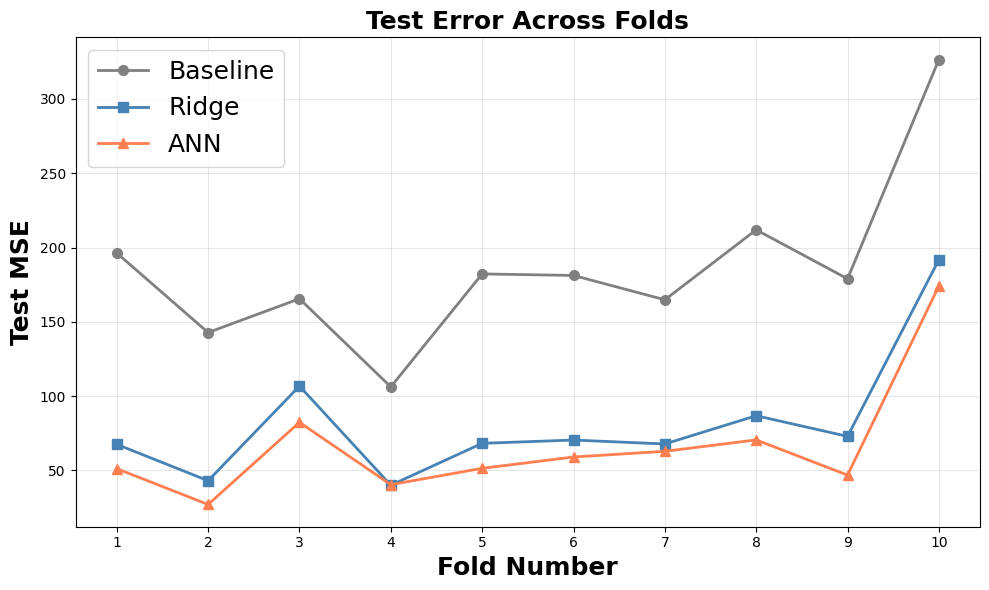

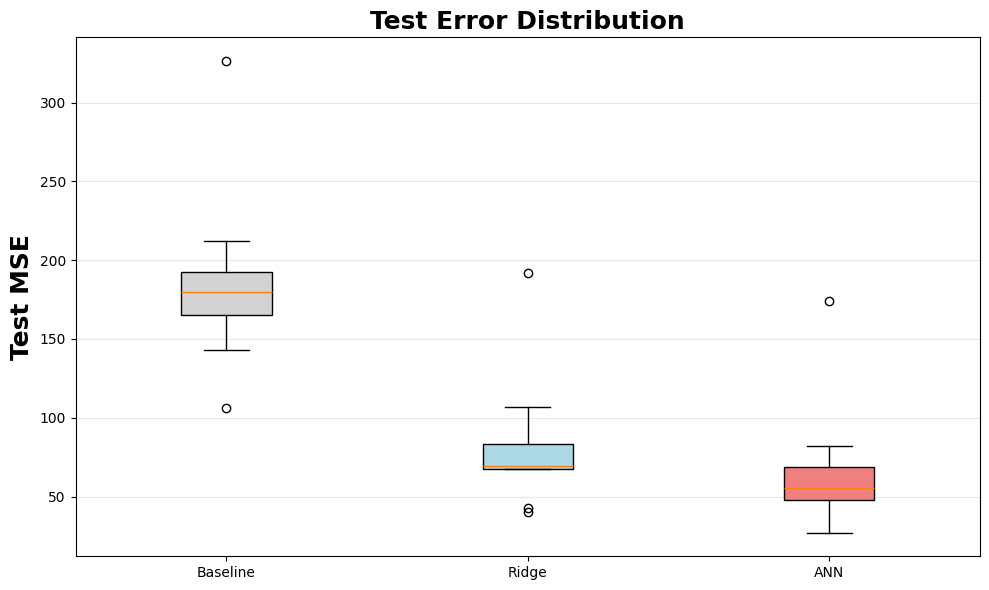

In [16]:
# STEP 7: VISUALIZATIONS

# GRÁFICO 1: Error Across Folds
plt.figure(figsize=(10, 6))
fold_nums = np.arange(1, K_outer + 1)
plt.plot(fold_nums, test_errors['Baseline'], 'o-', color='gray', 
         label='Baseline', linewidth=2, markersize=7)
plt.plot(fold_nums, test_errors['Ridge'], 's-', color='steelblue', 
         label='Ridge', linewidth=2, markersize=7)
plt.plot(fold_nums, test_errors['ANN'], '^-', color='coral', 
         label='ANN', linewidth=2, markersize=7)
plt.xlabel('Fold Number', fontsize=18, fontweight='bold')
plt.ylabel('Test MSE', fontsize=18, fontweight='bold')
plt.title('Test Error Across Folds', fontsize=18, fontweight='bold')
plt.legend(loc='best', fontsize=18)
plt.grid(True, alpha=0.3)
plt.xticks(fold_nums)
plt.tight_layout()
plt.show()


# GRÁFICO 2: Box Plot of Test Errors
plt.figure(figsize=(10, 6))
models = ['Baseline', 'Ridge', 'ANN']
data_to_plot = [test_errors['Baseline'], test_errors['Ridge'], test_errors['ANN']]
bp = plt.boxplot(data_to_plot, labels=models, patch_artist=True)
bp['boxes'][0].set_facecolor('lightgray')
bp['boxes'][1].set_facecolor('lightblue')
bp['boxes'][2].set_facecolor('lightcoral')
plt.ylabel('Test MSE', fontsize=18, fontweight='bold')
plt.title('Test Error Distribution', fontsize=18, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

In [20]:
# STEP 8: STATISTICAL EVALUATION (Setup I - Paired t-test)

import scipy.stats as st

def paired_ttest_comparison(errors_A, errors_B, alpha=0.05):
    # Calculate differences (z_i = error_A_i - error_B_i)
    z = np.array(errors_A) - np.array(errors_B)
    z_hat = np.mean(z)
    
    # Sample size and degrees of freedom
    n = len(z)
    nu = n - 1
    
    # Standard error of the mean
    sem = np.sqrt(np.sum((z - z_hat)**2) / (n * nu))
    # Alternative: sem = st.sem(z)
    
    # Confidence interval
    CI = st.t.interval(1 - alpha, df=nu, loc=z_hat, scale=sem)
    
    # p-value for two-sided test
    t_stat = -np.abs(z_hat) / st.sem(z)
    p_value = 2 * st.t.cdf(t_stat, df=nu)
    
    return z_hat, CI, p_value


# Perform pairwise comparisons
alpha = 0.05

print("=" * 70)
print("STATISTICAL COMPARISON - PAIRED T-TEST (Setup I)")
print("=" * 70)

# 1. Ridge vs Baseline
z_hat_ridge_baseline, CI_ridge_baseline, p_value_ridge_baseline = paired_ttest_comparison(
    test_errors['Ridge'], 
    test_errors['Baseline'], 
    alpha=alpha
)

print("\n1. RIDGE vs BASELINE")
print("-" * 50)
print(f"Mean difference (Ridge - Baseline): {z_hat_ridge_baseline:.4f}")
print(f"Confidence Interval (95%): [{CI_ridge_baseline[0]:.4f}, {CI_ridge_baseline[1]:.4f}]")
print(f"p-value: {p_value_ridge_baseline:.6f}")
if p_value_ridge_baseline < alpha:
    print(f"Result: SIGNIFICANT difference (p < {alpha})")
    if z_hat_ridge_baseline < 0:
        print("Conclusion: Ridge is significantly BETTER than Baseline")
    else:
        print("Conclusion: Ridge is significantly WORSE than Baseline")
else:
    print(f"Result: NO significant difference (p >= {alpha})")
    print("Conclusion: Models perform similarly")


# 2. ANN vs Baseline
z_hat_ann_baseline, CI_ann_baseline, p_value_ann_baseline = paired_ttest_comparison(
    test_errors['ANN'], 
    test_errors['Baseline'], 
    alpha=alpha
)

print("\n2. ANN vs BASELINE")
print("-" * 50)
print(f"Mean difference (ANN - Baseline): {z_hat_ann_baseline:.4f}")
print(f"Confidence Interval (95%): [{CI_ann_baseline[0]:.4f}, {CI_ann_baseline[1]:.4f}]")
print(f"p-value: {p_value_ann_baseline:.6f}")
if p_value_ann_baseline < alpha:
    print(f"Result: SIGNIFICANT difference (p < {alpha})")
    if z_hat_ann_baseline < 0:
        print("Conclusion: ANN is significantly BETTER than Baseline")
    else:
        print("Conclusion: ANN is significantly WORSE than Baseline")
else:
    print(f"Result: NO significant difference (p >= {alpha})")
    print("Conclusion: Models perform similarly")


# 3. ANN vs Ridge
z_hat_ann_ridge, CI_ann_ridge, p_value_ann_ridge = paired_ttest_comparison(
    test_errors['ANN'], 
    test_errors['Ridge'], 
    alpha=alpha
)

print("\n3. ANN vs RIDGE")
print("-" * 50)
print(f"Mean difference (ANN - Ridge): {z_hat_ann_ridge:.4f}")
print(f"Confidence Interval (95%): [{CI_ann_ridge[0]:.4f}, {CI_ann_ridge[1]:.4f}]")
print(f"p-value: {p_value_ann_ridge:.6f}")
if p_value_ann_ridge < alpha:
    print(f"Result: SIGNIFICANT difference (p < {alpha})")
    if z_hat_ann_ridge < 0:
        print("Conclusion: ANN is significantly BETTER than Ridge")
    else:
        print("Conclusion: ANN is significantly WORSE than Ridge")
else:
    print(f"Result: NO significant difference (p >= {alpha})")
    print("Conclusion: Models perform similarly")


# Summary table
print("\n" + "=" * 70)
print("SUMMARY TABLE")
print("=" * 70)
print(f"{'Comparison':<25} {'Mean Diff':<12} {'CI Lower':<12} {'CI Upper':<12} {'p-value':<12}")
print("-" * 70)
print(f"{'Ridge - Baseline':<25} {z_hat_ridge_baseline:>11.4f} {CI_ridge_baseline[0]:>11.4f} {CI_ridge_baseline[1]:>11.4f} {p_value_ridge_baseline:>11.6f}")
print(f"{'ANN - Baseline':<25} {z_hat_ann_baseline:>11.4f} {CI_ann_baseline[0]:>11.4f} {CI_ann_baseline[1]:>11.4f} {p_value_ann_baseline:>11.6f}")
print(f"{'ANN - Ridge':<25} {z_hat_ann_ridge:>11.4f} {CI_ann_ridge[0]:>11.4f} {CI_ann_ridge[1]:>11.4f} {p_value_ann_ridge:>11.6f}")
print("=" * 70)

print("\nNOTE: Negative mean difference indicates first model performs better (lower MSE)")
print(f"Significance level: α = {alpha}")

STATISTICAL COMPARISON - PAIRED T-TEST (Setup I)

1. RIDGE vs BASELINE
--------------------------------------------------
Mean difference (Ridge - Baseline): -104.0909
Confidence Interval (95%): [-122.0781, -86.1038]
p-value: 0.000000
Result: SIGNIFICANT difference (p < 0.05)
Conclusion: Ridge is significantly BETTER than Baseline

2. ANN vs BASELINE
--------------------------------------------------
Mean difference (ANN - Baseline): -119.0422
Confidence Interval (95%): [-139.0369, -99.0475]
p-value: 0.000000
Result: SIGNIFICANT difference (p < 0.05)
Conclusion: ANN is significantly BETTER than Baseline

3. ANN vs RIDGE
--------------------------------------------------
Mean difference (ANN - Ridge): -14.9513
Confidence Interval (95%): [-20.6714, -9.2312]
p-value: 0.000225
Result: SIGNIFICANT difference (p < 0.05)
Conclusion: ANN is significantly BETTER than Ridge

SUMMARY TABLE
Comparison                Mean Diff    CI Lower     CI Upper     p-value     
------------------------------

**CLASSIFICATION**

In [47]:
# Data configuration
X = df.drop(columns=['Y1_price','Y2_pcategory'])
y = df['Y2_pcategory']

# Store true values & predictions
y_true = []
y_true_baseline = []
y_true_lr = []
y_true_dt = []
y_preds = {"Model_Baseline": [], "Model_LinearRegression": [], "Model_DecisionTree": []}
model_names = list(y_preds.keys())

# New grids including additional regularization for the tree
lr_param_grid = {'C': np.logspace(-1, 3, 5)}  # [0.1, 1, 10, 100, 1000]
dt_param_grid = {
    'max_depth': [1, 2, 3, 4],
    'min_samples_leaf': [1, 5, 10],
    'min_samples_split': [2, 5, 10]
}

outer_cv = StratifiedKFold(n_splits=10, shuffle=True)
inner_cv = StratifiedKFold(n_splits=5, shuffle=True)

results = []

for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), start=1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Baseline: mayoritaria
    majority_class = y_train.mode()[0]
    y_pred_baseline = np.full(len(y_test), majority_class)
    baseline_error = np.mean(y_pred_baseline != y_test)
    # Store predictions in dictionary
    y_preds[model_names[0]].append(y_pred_baseline)
    y_true_baseline.append(y_test)
    y_true.append(y_test)
    
    # Logistic Regression con búsqueda
    lr_grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid=lr_param_grid, 
                           cv=inner_cv, scoring='accuracy', n_jobs=-1)
    lr_grid.fit(X_train, y_train)
    y_pred_lr = lr_grid.best_estimator_.predict(X_test)
    lr_error = np.mean(y_pred_lr != y_test)
        # Store predictions in dictionary
    y_preds[model_names[1]].append(y_pred_lr)
    y_true_lr.append(y_test)
    y_true.append(y_test)

    # Decision Tree con búsqueda de hiperparámetros extendida
    dt_grid = GridSearchCV(DecisionTreeClassifier(), param_grid=dt_param_grid,
                           cv=inner_cv, scoring='accuracy', n_jobs=-1)
    dt_grid.fit(X_train, y_train)
    y_pred_dt = dt_grid.best_estimator_.predict(X_test)
    dt_error = np.mean(y_pred_dt != y_test)
        # Store predictions in dictionary
    y_preds[model_names[2]].append(y_pred_dt)
    y_true_dt.append(y_test)
    y_true.append(y_test)



    results.append({
        'fold': fold,
        'dt_best_depth': dt_grid.best_params_['max_depth'],
        'dt_min_samples_leaf': dt_grid.best_params_['min_samples_leaf'],
        'dt_min_samples_split': dt_grid.best_params_['min_samples_split'],
        'dt_error': round(dt_error * 100, 2),
        'lr_best_C': round(lr_grid.best_params_['C'], 4),
        'lr_error': round(lr_error * 100, 2),
        'baseline_error': round(baseline_error * 100, 2)
    })

results_df = pd.DataFrame(results)

print(results_df)

# Concatenate the list of arrays into a single array
y_true = np.concatenate(y_true)
y_true_baseline = np.concatenate(y_true_baseline)
y_true_lr = np.concatenate(y_true_lr)
y_true_dt = np.concatenate(y_true_dt)
# Concatenate predictions for each model
y_preds = {model: np.concatenate(model_preds) for model, model_preds in y_preds.items()}
y_trues = {
    "Model_Baseline": y_true_baseline,
    "Model_LinearRegression": y_true_lr,
    "Model_DecisionTree": y_true_dt
}


   fold  dt_best_depth  dt_min_samples_leaf  dt_min_samples_split  dt_error  \
0     1              3                    5                     2     11.90   
1     2              4                    5                     2      9.52   
2     3              4                    5                     2     19.05   
3     4              3                    5                     2     11.90   
4     5              1                    1                     2     17.07   
5     6              3                    5                     2     14.63   
6     7              4                    1                     2     12.20   
7     8              4                    5                     2     21.95   
8     9              4                    5                     5     14.63   
9    10              3                    5                     2     17.07   

   lr_best_C  lr_error  baseline_error  
0       10.0      9.52           50.00  
1       10.0     11.90           50.00  
2      

2. Summary Statistics and Table for the Report

In [49]:
print("\nMean error rates (percentage):")
print(results_df[['dt_error', 'lr_error', 'baseline_error']].mean())
print("\nStd deviation error rates (percentage):")
print(results_df[['dt_error', 'lr_error', 'baseline_error']].std())

# 3. To LaTeX, matching the structure
latex_table = table_df.to_latex(index=False, float_format="%.4f", column_format='|l|rrrrrrrr|', caption='Model Comparison Table', label='tab:model_comparison')
print(latex_table)


Mean error rates (percentage):
dt_error          14.992
lr_error          17.879
baseline_error    50.732
dtype: float64

Std deviation error rates (percentage):
dt_error          3.809905
lr_error          6.237808
baseline_error    0.630005
dtype: float64
\begin{table}
\caption{Model Comparison Table}
\label{tab:model_comparison}
\begin{tabular}{|l|rrrrrrrr|}
\toprule
fold & dt_best_depth & dt_min_samples_leaf & dt_min_samples_split & dt_error & lr_best_C & lr_error & baseline_error \\
\midrule
1 & 3.0000 & 5.0000 & 2.0000 & 14.2900 & 1.0000 & 14.2900 & 50.0000 \\
2 & 3.0000 & 5.0000 & 2.0000 & 23.8100 & 10.0000 & 35.7100 & 50.0000 \\
3 & 4.0000 & 5.0000 & 2.0000 & 14.2900 & 1.0000 & 11.9000 & 50.0000 \\
4 & 4.0000 & 1.0000 & 5.0000 & 23.8100 & 0.1000 & 16.6700 & 50.0000 \\
5 & 3.0000 & 1.0000 & 2.0000 & 17.0700 & 1.0000 & 19.5100 & 51.2200 \\
6 & 4.0000 & 5.0000 & 2.0000 & 19.5100 & 0.1000 & 19.5100 & 51.2200 \\
7 & 3.0000 & 1.0000 & 5.0000 & 14.6300 & 1.0000 & 12.2000 & 51.2200 \\

For the report: "We compared a baseline, logistic regression, and a decision tree for binary classification using nested cross-validation. For each outer fold, we selected the best complexity parameters via inner cross-validation: the regularization parameter C for logistic regression and tree depth, min_samples_leaf & min_samples_split for decision tree. The table below summarizes the chosen parameters and resulting classification error rates per fold. The graphical plot further visualizes the comparative performance of these models."

3. Graphical Output (Bar Plot for Comparison)

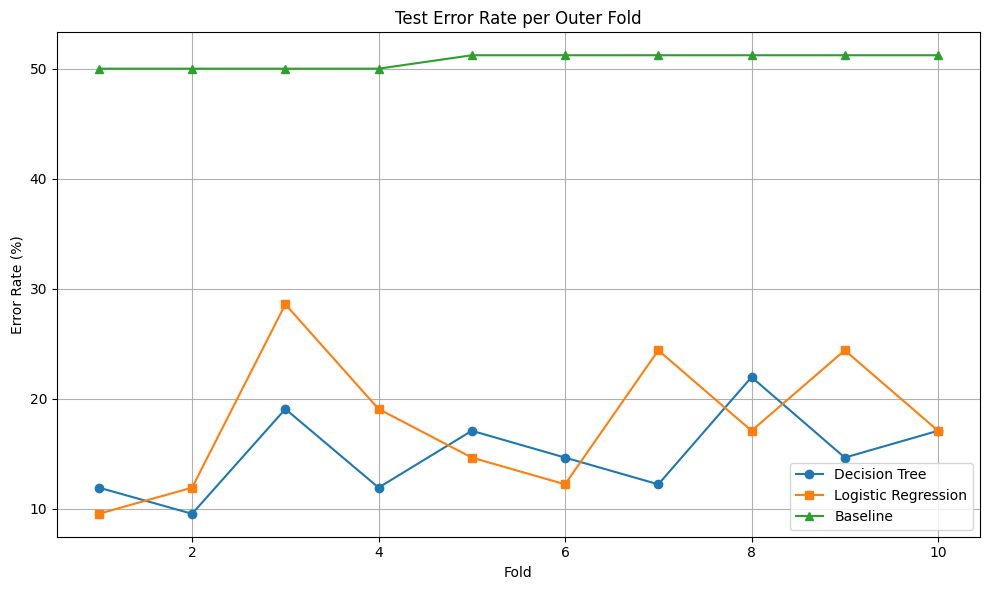

In [50]:
plt.figure(figsize=(10, 6))
plt.plot(results_df['fold'], results_df['dt_error'], marker='o', label='Decision Tree')
plt.plot(results_df['fold'], results_df['lr_error'], marker='s', label='Logistic Regression')
plt.plot(results_df['fold'], results_df['baseline_error'], marker='^', label='Baseline')
plt.xlabel('Fold')
plt.ylabel('Error Rate (%)')
plt.title('Test Error Rate per Outer Fold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Compute and print accuracies
accuracy = np.mean(y_preds['Model_Baseline'] == y_true_baseline)
print(f"Accuracy of Baseline Model: {accuracy:.4f}")
accuracy = np.mean(y_preds['Model_LinearRegression'] == y_true_lr)
print(f"Accuracy of Logistic Regression: {accuracy:.4f}")
accuracy = np.mean(y_preds['Model_DecisionTree'] == y_true_dt)
print(f"Accuracy of Decision Tree: {accuracy:.4f}")

Accuracy of Baseline Model: 0.4928
Accuracy of Logistic Regression: 0.8213
Accuracy of Decision Tree: 0.8502


In [52]:
def jeffrey_interval(y_trues, y_preds, alpha=0.05):
    # Total number of predictions
    n = len(y_trues)

    ### BEGIN SOLUTION
    # Number of correct predictions
    m = sum(y_trues == y_preds)

    # a, b
    a = m + 0.5
    b = n - m + 0.5

    # Confidence interval:
    CI = st.beta.interval(1 - alpha, a=a, b=b)

    # Point estimate:
    theta_hat = a / (a + b)

    ### END SOLUTION
    return theta_hat, CI

# Compute the Jeffreys interval
alpha = 0.05

for model_name in y_preds.keys():
    theta_hat, CI = jeffrey_interval(y_trues[model_name], y_preds[model_name], alpha=alpha)
    print(f"{model_name}: Theta point estimate {theta_hat:.4f}, CI: [{CI[0]:.4f}, {CI[1]:.4f}]")

Model_Baseline: Theta point estimate 0.4928, CI: [0.4448, 0.5408]
Model_LinearRegression: Theta point estimate 0.8205, CI: [0.7822, 0.8559]
Model_DecisionTree: Theta point estimate 0.8494, CI: [0.8135, 0.8821]


In [53]:
def mcnemar(y_true, yhatA, yhatB, alpha=0.05):
    """
    Perform McNemar's test to compare the accuracy of two classifiers.

    Parameters:
    - y_true: array-like, true labels
    - yhatA: array-like, predicted labels by classifier A
    - yhatB: array-like, predicted labels by classifier B
    - alpha: float, significance level (default: 0.05)

    Returns:
    - E_theta: float, estimated difference in accuracy between classifiers A and B (theta_hat)
    - CI: tuple, confidence interval of the estimated difference in accuracy
    - p: float, p-value for the two-sided test of whether classifiers A and B have the same accuracy
    """

    # Set up the contingency table
    nn = np.zeros((2, 2))

    # 2.1) Fill in the contingency table
    ### BEGIN SOLUTION
    # Correctness indicators
    cA = yhatA == y_true
    cB = yhatB == y_true

    # Fill the contingency table
    nn[0, 0] = sum([cA[i] * cB[i] for i in range(len(cA))]) 
    # Or a bit smarter: nn[0, 0] = sum(cA & cB)
    nn[0, 1] = sum(cA & ~cB)
    nn[1, 0] = sum(~cA & cB)
    nn[1, 1] = sum(~cA & ~cB)
    ### END SOLUTION

    # get values from the contingency table
    n = len(y_true)
    n12 = nn[0, 1]
    n21 = nn[1, 0]

    # 2.2) Calculate E_theta and Q from the values in the contingency table
    ### BEGIN SOLUTION
    E_theta = (n12 - n21) / n

    Q = (
        n**2
        * (n + 1)
        * (E_theta + 1)
        * (1 - E_theta)
        / ((n * (n12 + n21) - (n12 - n21) ** 2))
    )
    ### END SOLUTION


    # 2.3) Calculate f and g for the beta distribution
    ### BEGIN SOLUTION
    f = (E_theta + 1)/2 * (Q - 1)
    g = (1 - E_theta)/2 * (Q - 1)
    ### END SOLUTION

    # Calculate confidence interval
    CI = tuple(bound * 2 - 1 for bound in st.beta.interval(1 - alpha, a=f, b=g))

    # Calculate p-value for the two-sided test using exact binomial test
    p = 2 * st.binom.cdf(min([n12, n21]), n=n12 + n21, p=0.5)

    print(f"Result of McNemars test using alpha = {alpha}\n")
    print("Contingency table")
    print(nn, "\n")
    if n12 + n21 <= 10:
        print("Warning, n12+n21 is low: n12+n21=", (n12 + n21))

    print(f"Approximate 1-alpha confidence interval of theta: [thetaL,thetaU] = {CI[0]:.4f}, {CI[1]:.4f}\n")
    print(
        f"p-value for two-sided test A and B have same accuracy (exact binomial test): p={p}\n"
    )

    return E_theta, CI, p

In [54]:
# Compute the Jeffreys interval
alpha = 0.05
[theta_hat, CI, p] = mcnemar(y_trues['Model_Baseline'], y_preds['Model_Baseline'], y_preds['Model_LinearRegression'], alpha=alpha)

print(f"theta = theta_A-theta_B point estimate: {theta_hat}\n CI: [{CI[0]:.4f}, {CI[1]:.4f}]\n p-value: {p}")

Result of McNemars test using alpha = 0.05

Contingency table
[[158.  46.]
 [182.  28.]] 

Approximate 1-alpha confidence interval of theta: [thetaL,thetaU] = -0.3918, -0.2638

p-value for two-sided test A and B have same accuracy (exact binomial test): p=2.4978251715776746e-20

theta = theta_A-theta_B point estimate: -0.3285024154589372
 CI: [-0.3918, -0.2638]
 p-value: 2.4978251715776746e-20


In [55]:
# Compute the Jeffreys interval
alpha = 0.05
[theta_hat, CI, p] = mcnemar(y_trues['Model_Baseline'], y_preds['Model_Baseline'], y_preds['Model_DecisionTree'], alpha=alpha)

print(f"theta = theta_A-theta_B point estimate: {theta_hat}\n CI: [{CI[0]:.4f}, {CI[1]:.4f}]\n p-value: {p}")

Result of McNemars test using alpha = 0.05

Contingency table
[[172.  32.]
 [180.  30.]] 

Approximate 1-alpha confidence interval of theta: [thetaL,thetaU] = -0.4164, -0.2971

p-value for two-sided test A and B have same accuracy (exact binomial test): p=3.299924798986378e-26

theta = theta_A-theta_B point estimate: -0.357487922705314
 CI: [-0.4164, -0.2971]
 p-value: 3.299924798986378e-26


In [62]:
# Compute the Jeffreys interval
alpha = 0.05
[theta_hat, CI, p] = mcnemar(y_trues['Model_Baseline'], y_preds['Model_LinearRegression'], y_preds['Model_DecisionTree'], alpha=alpha)

print(f"theta = theta_A-theta_B point estimate: {theta_hat}\n CI: [{CI[0]:.4f}, {CI[1]:.4f}]\n p-value: {p}")

Result of McNemars test using alpha = 0.05

Contingency table
[[314.  26.]
 [ 38.  36.]] 

Approximate 1-alpha confidence interval of theta: [thetaL,thetaU] = -0.0667, 0.0088

p-value for two-sided test A and B have same accuracy (exact binomial test): p=0.16864291143970336

theta = theta_A-theta_B point estimate: -0.028985507246376812
 CI: [-0.0667, 0.0088]
 p-value: 0.16864291143970336


In [57]:
# Recupera el mejor valor de C (inverso de lambda)
best_C = results_df['lr_best_C'].mode()[0]  # o el que consideres más representativo

# Entrena el modelo en todo el conjunto de datos
final_lr = LogisticRegression(C=best_C, max_iter=1000)
final_lr.fit(X, y)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,np.float64(10.0)
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


Coeficientes regresión logística:
X5_distcenter    0.694382
X4_stores       -0.191327
X2_age           0.063764
X3_distMRTT      0.001859
dtype: float64


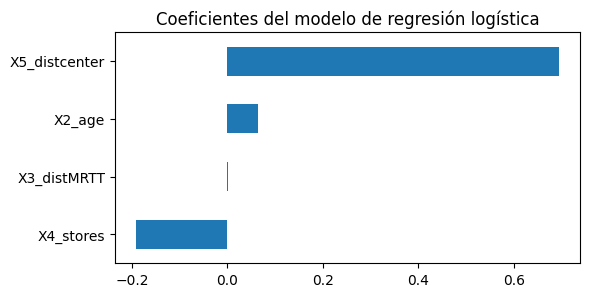

In [61]:
coefs = pd.Series(final_lr.coef_[0], index=X.columns)
print("Coeficientes regresión logística:")
print(coefs.sort_values(key=abs, ascending=False))

# Visualización
plt.figure(figsize=(6,3))
coefs.sort_values().plot(kind='barh')
plt.title('Coeficientes del modelo de regresión logística')
plt.show()